<h1><center><font size="6">IEEE FRAUD DETECTION</font></center></h1>




<img src="https://gdprinformer.com/wp-content/uploads/2017/09/fraud-laptop.jpg" width="800"></img>



<br>

# <a id='0'>Content</a>

- <a href='#1'>Importing Libraries and Modules</a>  
- <a href='#2'>Distribution of features across Train and Test</a>
 - <a href='#21'>Card Features</a>   
  - <a href='#22'>Addr,Dist and EmailDomain</a>  
  - <a href='#23'>C Features</a> 
  - <a href='#24'>D Features</a> 
  - <a href='#25'>M features</a> 
  - <a href='#26'>V Features</a>   
  - <a href='#27'>ID features</a> 
- <a href='#3'>Dropping Columns</a>   
- <a href='#4'>Reducing Memory Size</a>    
- <a href='#5'>Feature Engineering</a>     
- <a href='#6'>Model Development</a>
- <a href='#7'>Feature Importance</a>


**Please upvote if you like the kernel . Happy Kaggling and all the best for the competition**

# <a id='1'>Importing Libraries and Modules</a> 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin
import gc
import os
print(os.listdir("../input"))
seed=5
# Any results you write to the current directory are saved as output.

['train_identity.csv', 'train_transaction.csv', 'test_transaction.csv', 'test_identity.csv', 'sample_submission.csv']


In [2]:
train_identity=pd.read_csv('../input/train_identity.csv')
test_identity=pd.read_csv('../input/test_identity.csv')
train_transaction=pd.read_csv('../input/train_transaction.csv')
test_transaction=pd.read_csv('../input/test_transaction.csv')

In [3]:
train=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
test=pd.merge(test_transaction,test_identity,how='left',on='TransactionID')

In [4]:
del train_identity,test_identity,train_transaction,test_transaction

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [6]:
# many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
# many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [7]:
# big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
# big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [8]:
# one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
# one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [9]:
# cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
# len(cols_to_drop)

In [10]:
drop_cols=['dist2','C8','C9','C10','D6','D12','V27','V28','V45','V70','V71','V77','V78','V86','V87','V89','V91','V92','V95','V96','V97',
          'V101','V102','V103','V107','V126','V127','V128','V130','V131','V132','V133','V134','V135','V136','V137','V143','V145','V150',
          'V159','V160','V164','V165','V166','V167','V168','V171','V176','V177','V178','V179','V181','V182','V183','V190','V199','V202',
          'V203','V204','V207','V211','V212','V213','V214','V215','V216','V221','V226','V227','V228','V230','V234','V240','V241','V245',
          'V246','V255','V256','V257','V258','V259','V261','V263','V264','V265','V270','V271','V272','V273','V274','V275','V276','V277',
          'V278','V279','V280','V291','V292','V293','V294','V295','V297','V306','V307','V308','V310','V312','V316','V317','V318','V319',
          'V320','V321','V322','V323','V324','V331','V332','V333','V338','V339','TransactionDT','TransactionID']



In [11]:
# remnant_cols=list(set(drop_cols)-set(drop_cols).intersection(set(cols_to_drop)))

In [12]:
train=train.drop(drop_cols,1)
test=test.drop(drop_cols,1)
train['TransactionAmt']=np.log(train['TransactionAmt'])
test['TransactionAmt']=np.log(test['TransactionAmt'])

In [13]:
# most_null_values=[col for col in train.columns if (train[col].isna().sum()/train.shape[0])>0.9]
# len(most_null_values)

In [14]:
# dominant_unique_values=[col for col in train.columns if (train[col].value_counts().values[0]/train.shape[0])>0.9]
# len(dominant_unique_values)

In [15]:
# dominant_unique_values.remove('isFraud')

In [16]:
# cols_to_drop=list(set(most_null_values+dominant_unique_values+['TransactionID','TransactionDT']))
# train=train.drop(cols_to_drop,axis=1)
# test=test.drop(cols_to_drop,axis=1)

# <a id='3'>Dropping Columns</a> 

In [17]:

# drop_col = ['TransactionDT','TransactionID','V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102', 'V123', 
#             'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318', 'V103', 'V304', 'V116', 'V298', 
#             'V284', 'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 
#             'V122', 'V319', 'V105', 'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']

# drop_col=['TransactionDT','TransactionID']
# train=train.drop(drop_col,1)
# test=test.drop(drop_col,1)

# <a id='4'>Reducing memory size</a> 

In [18]:
# %%time
# # From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# # WARNING! THIS CAN DAMAGE THE DATA 
# def reduce_mem_usage(df):
#     """ iterate through all the columns of a dataframe and modify the data type
#         to reduce memory usage.        
#     """
#     start_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
#     for col in df.columns:
#         col_type = df[col].dtype
        
#         if col_type != object:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
#     return df

In [19]:
# train=reduce_mem_usage(train)
# test=reduce_mem_usage(test)

In [20]:
# obj_cols=[col for col in train.columns if train[col].dtype=='object']
# if 'isFraud' in obj_cols:
#     obj_cols.remove('isFraud')
    
# unique_values=sorted([(col,train[col].nunique()+test[col].nunique()) for col in obj_cols],key=lambda x: x[1],reverse=False)

In [21]:
# dummy_cols=[col[0] for col in unique_values[:18]]
# target=train['isFraud']
# train=train.drop('isFraud',1)
# ntrain=train.shape[0]
# print(train.shape)
# merged_data=pd.concat([train,test],axis=0,ignore_index=True)
# X=pd.get_dummies(merged_data,columns=dummy_cols)
# merged_data.drop(dummy_cols,axis=1,inplace=True)
# merged_data=pd.concat([merged_data,X],axis=1)
# del X
# train=merged_data[:ntrain]
# test=merged_data[ntrain:]
# print(train.shape)
# del merged_data
# gc.collect()

# <a id='5'>Feature Engineering</a> 

In [22]:
num_cols=[col for col in train.columns if (('float' in str(train[col].dtype)) or ('int' in str(train[col].dtype)))]
num_cols.remove('isFraud')
train['mean']=train[num_cols].mean(axis=1)
test['mean']=test[num_cols].mean(axis=1)
train['std']=train[num_cols].std(axis=1)
test['std']=test[num_cols].std(axis=1)
train['max']=train[num_cols].max(axis=1)
test['max']=test[num_cols].max(axis=1)
train['min']=train[num_cols].min(axis=1)
test['min']=test[num_cols].min(axis=1)
train['median']=train[num_cols].median(axis=1)
test['median']=test[num_cols].median(axis=1)
train['skew']=train[num_cols].skew(axis=1)
test['skew']=test[num_cols].skew(axis=1)
train['kurt']=train[num_cols].kurt(axis=1)
test['kurt']=test[num_cols].kurt(axis=1)

Randomly generating some features. Very illogical I know :P

In [23]:
# columns=['TransactionAmt','card1','card2','addr2','dist1','C1','C2','D1','D2','V1','V2',
#         'id_01','id_02']
# obj_cols=['DeviceInfo','card4','card6','ProductCD','DeviceType']

# for col in columns:
#     for feat in obj_cols:
#         train[f'{col}_mean_group_{feat}']=train[col]/train.groupby(feat)[col].transform('mean')
#         test[f'{col}_mean_group_{feat}']=test[col]/test.groupby(feat)[col].transform('mean')
#         train[f'{col}_max_group_{feat}']=train[col]/train.groupby(feat)[col].transform('max')
#         test[f'{col}_max_group_{feat}']=test[col]/test.groupby(feat)[col].transform('max')
#         train[f'{col}_min_group_{feat}']=train[col]/train.groupby(feat)[col].transform('min')
#         test[f'{col}_min_group_{feat}']=test[col]/test.groupby(feat)[col].transform('min')
#         train[f'{col}_skew_group_{feat}']=train[col]/train.groupby(feat)[col].transform('skew')
#         test[f'{col}_skew_group_{feat}']=test[col]/test.groupby(feat)[col].transform('skew')
#         train[f'{col}_skew_group_{feat}']=train[col]/train.groupby(feat)[col].transform('count')
#         test[f'{col}_skew_group_{feat}']=test[col]/test.groupby(feat)[col].transform('count')
   

In [24]:
# def fill_missing(df):
#     num_cols=[col for col in df.columns if df[col].dtype=='float64' or df[col].dtype=='int64']
#     for col in num_cols:
#         df[col]=df[col].fillna(df[col].mean())
#     obj_cols=[col for col in df.columns if df[col].dtype=='object']
#     for col in obj_cols:
#         df[col]=df[col].fillna(df[col].mode()[0])
        
#     return df

In [25]:
# train_df=fill_missing(train_df)
# test_df=fill_missing(test_df)

In [26]:
train=train.fillna(-999)
test=test.fillna(-999)

In [27]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

In [28]:
from sklearn.preprocessing import LabelEncoder

# object_cols=[col for col in train.columns if (('category' in str(train[col].dtype)) or ('object' in str(train[col].dtype)))]
le=LabelEncoder()
for col in cat_cols:
    le.fit(list(train[col].values)+list(test[col].values))
    train[col]=le.transform(list(train[col].values))
    test[col]=le.transform(list(test[col].values))

In [29]:
train.shape , test.shape

((590540, 318), (506691, 317))

In [30]:
target=train['isFraud']
train=train.drop('isFraud',1)

In [31]:
# from sklearn.model_selection import train_test_split
# train_X,val_X,train_y,val_y=train_test_split(train,target,test_size=0.2,random_state=seed,stratify=target)

In [32]:
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score


# def objective(params):
#     params=dict(max_depth=int(params['max_depth']),
#                subsample=np.round(params['subsample'],3),
#                colsample_bytree=np.round(params['colsample_bytree'],3),
#                learning_rate=np.round(params['learning_rate'],3),
#                verbosity=0)
    
#     clf=XGBClassifier(n_estimators=1000,random_state=seed,**params,tree_method='gpu_hist')
#     clf.fit(train_X,train_y,eval_set=[(val_X,val_y)],eval_metric='auc',early_stopping_rounds=10)
#     val_pred=clf.predict(val_X)
#     score=roc_auc_score(val_y,val_pred)
#     return score

# space={'max_depth':hp.quniform('max_depth',2,10,2),
#       'subsample':hp.uniform('subsample',0.1,1),
#       'colsample_bytree':hp.uniform('colsample_bytree',0.1,1),
#       'learning_rate':hp.uniform('learning_rate',0.01,0.1)}

# trial=Trials()
# best=fmin(fn=objective,algo=tpe.suggest,space=space,max_evals=100,trials=trial,rstate=np.random.RandomState(seed))

    

In [33]:
# best['max_depth']=int(best['max_depth'])
# print('Best parameters:',best)

In [34]:
# del train_X,val_X,train_y,val_y
# gc.collect()

In [35]:
# TID=[t['tid'] for t in trial.trials]
# Loss=[t['result']['loss'] for t in trial.trials]
# maxd=[t['misc']['vals']['max_depth'][0] for t in trial.trials]
# lr=[t['misc']['vals']['learning_rate'][0] for t in trial.trials]
# sub=[t['misc']['vals']['subsample'][0] for t in trial.trials]
# col_samp=[t['misc']['vals']['colsample_bytree'][0] for t in trial.trials]


# hyperopt_xgb=pd.DataFrame({'tid':TID,'loss':Loss,
#                           'max_depth':maxd,'learning_rate':lr,
#                           'subsample':sub, 'colsample_bytree':col_samp})

In [36]:
# plt.subplots(3,2,figsize=(10,10))
# plt.subplot(3,2,1)
# sns.scatterplot(x='tid',y='max_depth',data=hyperopt_xgb)
# plt.subplot(3,2,2)
# sns.scatterplot(x='tid',y='loss',data=hyperopt_xgb)
# plt.subplot(3,2,3)
# sns.scatterplot(x='tid',y='learning_rate',data=hyperopt_xgb)
# plt.subplot(3,2,4)
# sns.scatterplot(x='tid',y='subsample',data=hyperopt_xgb)
# plt.subplot(3,2,5)
# sns.scatterplot(x='tid',y='colsample_bytree',data=hyperopt_xgb)
# plt.subplot(3,2,6)
# sns.scatterplot(x='tid',y='loss',data=hyperopt_xgb)

# plt.tight_layout()

# <a id='6'>Model Development and Feature Importance</a> 

In [37]:
from sklearn.model_selection import StratifiedKFold
import gc

nfolds=10


xgb_params=dict(n_estimators=1000,
                verbosity=0,
                tree_method='gpu_hist',
                random_state=seed,
               colsample_bytree=0.6,
               subsample=0.6,
               learning_rate=0.05,
               max_depth=12)

lgb_params=dict(objective='binary',
               num_leaves=62,
               seed=seed,
               max_depth=9,
               pos_bagging_fraction=0.5,
               neg_bagging_fraction=1.0,
               bagging_freq=5,
               feature_fraction=0.9,
                metric='auc',
               learning_rate=0.05,
               verbosity=-1,
               device='gpu')


skfold=StratifiedKFold(nfolds,random_state=seed)



def build_model(params,model='xgb',plot_feature_importance=True):
    oof=np.zeros(train.shape[0])
    pred=np.zeros(test.shape[0])
    scores=[]
    feature_importance=pd.DataFrame()
    for i,(train_index,val_index) in enumerate(skfold.split(train,target)):
        print('Fold :',i+1)

        
        if model=='xgb':
            train_X,val_X=train.iloc[train_index,:],train.iloc[val_index,:]
            train_y,val_y=target[train_index],target[val_index]
            clf=XGBClassifier(**params)
            clf.fit(train_X,train_y,eval_metric='auc',eval_set=[(val_X,val_y)],early_stopping_rounds=10,verbose=20)
            val_pred=clf.predict_proba(val_X)[:,1]
        
        
        if model=='lgb':
        
            train_d=lgb.Dataset(train.iloc[train_index,:].values,label=target[train_index].values)
            val_d=lgb.Dataset(train.iloc[val_index,:].values,label=target[val_index].values)
            clf=lgb.train(params,train_d,num_boost_round=1000,valid_sets=[val_d],verbose_eval=20,early_stopping_rounds=10)
            val_pred=clf.predict(train.iloc[val_index,:].values)
        
    
        oof[val_index]=val_pred
        val_score=roc_auc_score(target[val_index],val_pred)
        scores.append(val_score)
        print(f'Validation score using {model} for fold {i} :'+ str(val_score))
        print('-'*100)
        
        if model=='xgb':
            pred+=clf.predict_proba(test)[:,1]/nfolds
        if model=='lgb':
            pred+=clf.predict(test.values)/nfolds
            
        if model=='xgb':
            del train_X,val_X,train_y,val_y
        if model=='lgb':
            del train_d,val_d
       
        gc.collect()
        
        
        fold_importance=pd.DataFrame()
        fold_importance['feature']=train.columns
        if model=='xgb':
            fold_importance['importance']=clf.feature_importances_
        if model=='lgb':
            fold_importance['importance']=clf.feature_importance()
        fold_importance['fold']=i+1
        feature_importance=pd.concat([feature_importance,fold_importance],axis=0)
            
            
    print('Mean validation score :',np.mean(scores)) 
    
    if plot_feature_importance:
        df=feature_importance[['feature','importance']].groupby('feature').mean().sort_values(by='importance',ascending=False).reset_index()
        plt.figure(figsize=(10,10))
        sns.barplot(x='importance',y='feature',data=df.iloc[:25,:])
        plt.title('Feature Importances')
        
    return pred

Fold : 1
[0]	validation_0-auc:0.799673
Will train until validation_0-auc hasn't improved in 10 rounds.
[20]	validation_0-auc:0.862093
[40]	validation_0-auc:0.871568
[60]	validation_0-auc:0.882773
[80]	validation_0-auc:0.895739
[100]	validation_0-auc:0.90508
[120]	validation_0-auc:0.911333
[140]	validation_0-auc:0.914925
[160]	validation_0-auc:0.917388
[180]	validation_0-auc:0.918217
[200]	validation_0-auc:0.919479
[220]	validation_0-auc:0.9204
Stopping. Best iteration:
[217]	validation_0-auc:0.920645

Validation score using xgb for fold 0 :0.9206452158304981
----------------------------------------------------------------------------------------------------
Fold : 2
[0]	validation_0-auc:0.810945
Will train until validation_0-auc hasn't improved in 10 rounds.
[20]	validation_0-auc:0.866192
[40]	validation_0-auc:0.878431
[60]	validation_0-auc:0.892568
[80]	validation_0-auc:0.903953
[100]	validation_0-auc:0.912334
[120]	validation_0-auc:0.919312
[140]	validation_0-auc:0.922327
[160]	valid

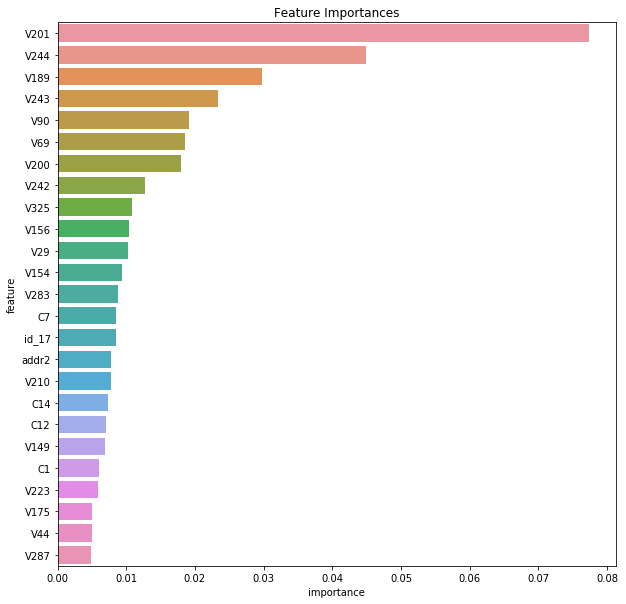

In [38]:
pred=build_model(xgb_params,model='xgb')

In [39]:
sub=pd.read_csv('../input/sample_submission.csv')
sub['isFraud']=pred
sub.to_csv('submission.csv',index=False)